<a href="https://colab.research.google.com/github/ajaynathani/POCs/blob/master/clickbait_or_not_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluation Criteria
- Data Story Telling: 10 marks - why chose this project, benefits, application, usecases
- Data Visualisation: 10 marks
- Data Understanding: 10 marks
- Exploratory Data Analysis: 10 marks
- Models and Approaches: 20 marks -- mid review
- Metrics and Results: 10 marks
- Business User Case of Technical Solution: 10 marks detailing on use case mentioned in story tellying from ROI perspective.
- Executive Summary: 10 marks nest to do infographic
- Code Demo Video: 10 marks

First 2 slides, motivation for the project and business use case
next few slied, problem definition,description of dataset,related work (optional)


Reference:
- https://github.com/AlisonSalerno/clickbait_detector/blob/master/final_mvp.ipynb
- https://towardsdatascience.com/is-this-headline-clickbait-86d27dc9b389

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import collections
from gensim.models import Word2Vec
import numpy as np

In [20]:
filepath = "/content/drive/MyDrive/data/clickbait/clickbait.json"
labelpath = "/content/drive/MyDrive/data/clickbait/truth.txt"

In [21]:
data=[]
data = [json.loads(line) for line in open(filepath, encoding="utf8")]
len(data)

21997

In [22]:
y = pd.read_csv(labelpath,header=None,names=['label'])
print(len(y))
y.head()

21997


,label
0,no-clickbait
1,no-clickbait
2,clickbait
3,no-clickbait
4,clickbait


In [23]:
data[0].keys()

dict_keys(['id', 'postTimestamp', 'postText', 'postMedia', 'targetTitle', 'targetDescription', 'targetKeywords', 'targetParagraphs', 'targetCaptions'])

In [24]:
data[2]

{'id': '609504474621612032',
 'postMedia': [],
 'postText': ['U.S. Soccer should start answering tough questions about Hope Solo, @eric_adelson writes.'],
 'postTimestamp': 'Fri Jun 12 23:36:05 +0000 2015',
 'targetCaptions': ['US to vote for Ali in FIFA election and not Blatter',
  'US to vote for Ali in FIFA election and not Blatter',
  "FILE - This Oct. 10, 2014, file photo shows Sunil Gulati, president of the United States Soccer Federation, during a press conference in Bristol, Conn. The United States says it will vote for Jordan's Prince Ali bin Al-Hussein for FIFA president Friday, May 29, 2015 and not for incumbent Sepp Blatter. (AP Photo/Elise Amendola, File)"],
 'targetDescription': "A U.S. Senator's scathing letter questioned U.S. Soccer's inadequate handling of Solo's domestic violence charges. It's time for Sunil Gulati to respond.",
 'targetKeywords': '',
 'targetParagraphs': ["WINNIPEG, Manitoba – The bubble U.S. Soccer is putting around Hope Solo isn't working to calm a

In [25]:
data_df = pd.DataFrame(data=data)

In [26]:
X = data_df.copy()

In [27]:
data_df['label'] = y

In [28]:
data_df.head()

,id,postTimestamp,postText,postMedia,targetTitle,targetDescription,targetKeywords,targetParagraphs,targetCaptions,label
0,608310377143799810,Tue Jun 09 16:31:10 +0000 2015,[Apple's iOS 9 'App thinning' feature will giv...,[],Apple gives back gigabytes: iOS 9 'app thinnin...,'App thinning' will be supported on Apple's iO...,"Apple,gives,gigabytes,iOS,9,app,thinning,featu...",[Paying for a 64GB phone only to discover that...,['App thinning' will be supported on Apple's i...,no-clickbait
1,609297109095972864,Fri Jun 12 09:52:05 +0000 2015,[RT @kenbrown12: Emerging market investors are...,[media/609297109095972864.jpg],Emerging Markets Suffer Largest Outflow in Sev...,Global investors have yanked $9.3 billion from...,"emerging market,emerging markets,em flows,em i...","[Emerging markets are out of favor., Global in...","[Stocks Fall as Investors Watch Central Banks,...",no-clickbait
2,609504474621612032,Fri Jun 12 23:36:05 +0000 2015,[U.S. Soccer should start answering tough ques...,[],U.S. Soccer should start answering tough quest...,A U.S. Senator's scathing letter questioned U....,,"[WINNIPEG, Manitoba – The bubble U.S. Soccer i...",[US to vote for Ali in FIFA election and not B...,clickbait
3,609748367049105409,Sat Jun 13 15:45:13 +0000 2015,[How theme parks like Disney World left the mi...,[],How theme parks like Disney World left the mid...,"America's top family vacation spots, like the ...","disney, disney world, disney ticket prices, di...",[When Walt Disney World opened in an Orlando s...,"[Some 1,000 persons turned out in Albuquerque,...",no-clickbait
4,608688782821453825,Wed Jun 10 17:34:49 +0000 2015,[Could light bulbs hurt your health? One compa...,[media/608688782821453825.jpg],Warning labels on your light bulbs,One company will put a health notice on all th...,"health, Should there be warning labels on your...",[(CNN)The light bulb always makes the world's ...,[Electric lights have made the world safer and...,clickbait


In [29]:
data_df.describe()

,id,postTimestamp,postText,postMedia,targetTitle,targetDescription,targetKeywords,targetParagraphs,targetCaptions,label
count,21997,21997,21997,21997,21997,21997,21997,21997,21997,21997
unique,21997,21916,21463,11930,21048,19928,12699,21139,16510,2
top,812387832417447937,Sat Feb 25 03:01:48 +0000 2017,[],[],CBSN - Live Streaming Video News Channel,,,[],[],no-clickbait
freq,1,3,54,10068,31,1135,8036,116,2958,16474


In [47]:
data_df['label'].value_counts()

no-clickbait    16474
clickbait        5523
Name: label, dtype: int64

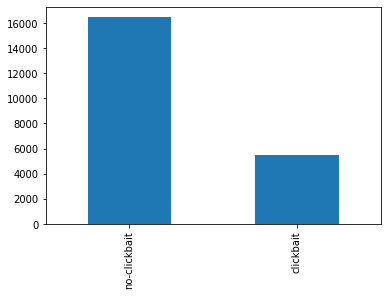

In [48]:
data_df['label'].value_counts().plot(kind='bar')

In [73]:
# Use top 80% for training and last 20% for testing.
X_train = X[:int(0.8*(len(X)))]
y_train = y[:int(0.8*(len(y)))]
X_test = X[int(0.8*(len(X))):]
y_test = y[int(0.8*(len(y))):]

In [74]:
X_train_df = X_train.copy()
X_train_df['label'] = y_train

X_test_df = X_test.copy()
X_test_df['label'] = y_test

In [60]:
y_train.value_counts()

label       
no-clickbait    13248
clickbait        4349
dtype: int64

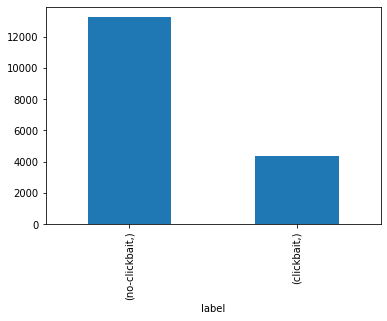

In [61]:
y_train.value_counts().plot(kind='bar')

In [76]:
X_train_df.postText

0        [Apple's iOS 9 'App thinning' feature will giv...
1        [RT @kenbrown12: Emerging market investors are...
2        [U.S. Soccer should start answering tough ques...
3        [How theme parks like Disney World left the mi...
4        [Could light bulbs hurt your health? One compa...
                               ...                        
17592    [Phones, guns and sodas: What you need to know...
17593    [Are you ready for an entirely new flying expe...
17594                                        [Very Gen X.]
17595    [Osama bin Laden's son Hamza has been put on a...
17596                              [Aqueducts and arbours]
Name: postText, Length: 17597, dtype: object

In [63]:
#Check if postText has multiple sentences
X_train_df['postText'].map(lambda x: len(x)>1).unique()

array([False])

In [77]:
#Converting postText list to text
X_train_df['postText']=X_train_df['postText'].map(lambda x:x[0])


In [78]:
X_train_df['postText']

0        Apple's iOS 9 'App thinning' feature will give...
1        RT @kenbrown12: Emerging market investors are ...
2        U.S. Soccer should start answering tough quest...
3        How theme parks like Disney World left the mid...
4        Could light bulbs hurt your health? One compan...
                               ...                        
17592    Phones, guns and sodas: What you need to know ...
17593    Are you ready for an entirely new flying exper...
17594                                          Very Gen X.
17595    Osama bin Laden's son Hamza has been put on a ...
17596                                Aqueducts and arbours
Name: postText, Length: 17597, dtype: object

In [79]:
#Imputing blank postText with targetTitle
X_train_df['postText'].replace([''], np.nan,inplace=True)
X_train_df['postText'].isnull().value_counts()

False    17557
True        40
Name: postText, dtype: int64

In [80]:
X_train_df['postText'].fillna(X_train_df['targetTitle'],inplace=True)


In [81]:
X_train_df['postText'].isnull().value_counts()

False    17597
Name: postText, dtype: int64

## WordCloud

In [82]:
stopwords = set(STOPWORDS)

In [83]:
def get_words(X):
  all_words = ''
  for sentence in X:
    tokens=[]
    for word in sentence.split(' '):
      if word.lower() not in stopwords:
        all_words+= word.lower() + " "
  return all_words



In [84]:
clickbait_words = get_words(X_train_df.loc[X_train_df['label']=='clickbait','postText'])
no_clickbait_words = get_words(X_train_df.loc[X_train_df['label']=='no-clickbait','postText'])

In [85]:
clickbait_words

'u.s. soccer start answering tough questions hope solo, @eric_adelson writes. light bulbs hurt health? one company now putting warning labels bulbs: 13 classic ’00s songs actually meant artists tourists detained malaysia getting naked sacred mountain: brutal dictatorship world keeps ignoring rt @bbcwalesnews: caerphilly farmer may payout worth hundreds thousands 24 year wait man dies car plunges parking garage 5 inconsistencies \'jurassic world\' will drive scientists crazy @bi_video rt @bbcos: secret history women\'s football dogs donate blood? global warming skeptics conference tell winning debate. nobel-winning sexism lab via @roomfordebate 5 incredible italian dishes tried rt @indyfootball: player ratings: jack wilshere comes age phil jones andros townsend endure shocker htt strongest female characters #jurassicworld humans map: islamic state neighborhood near you? academic group censures university illinois rescinded job offer india’s microloan meltdown taught one entrepreneur lif

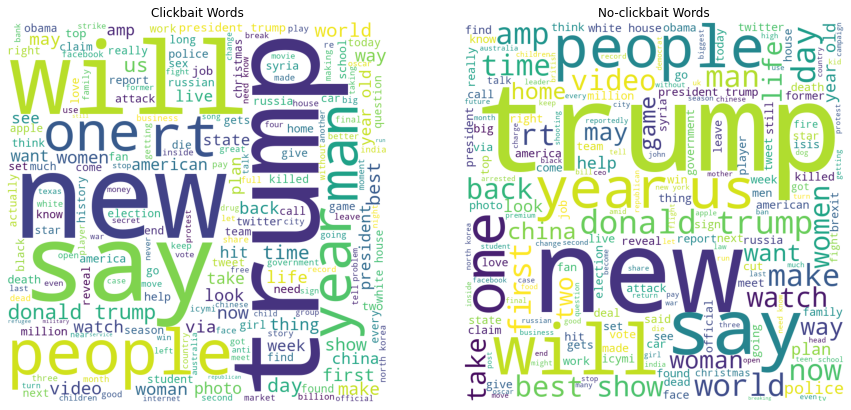

In [86]:
clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = stopwords,min_font_size = 10).generate(clickbait_words)
no_clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = stopwords,min_font_size = 10).generate(no_clickbait_words)
# plot the WordCloud image                        
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))

#plt.figure(figsize = (20, 20), facecolor = None) 
ax1.imshow(clickbait_wordcloud) 
ax1.axis("off") 
ax1.set_title("Clickbait Words")

ax2.imshow(no_clickbait_wordcloud) 
ax2.axis("off") 
ax2.set_title("No-clickbait Words")
  
plt.show()



In [87]:
#trump, new, say, will, people apper in both wordclouds. Let try wordcloud again after including these in stopwords.
custom_stopwords = {'trump','new','say','will','people','says','year','one','us',''}
custom_stopwords.update(stopwords)

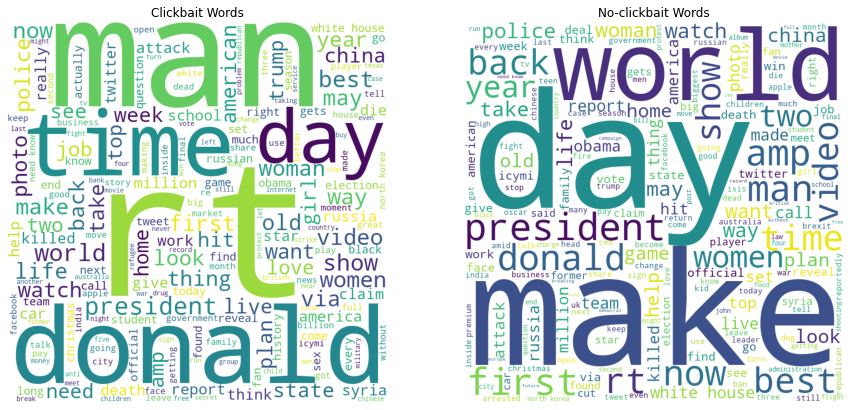

In [88]:
clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = custom_stopwords,min_font_size = 10).generate(clickbait_words)
no_clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = custom_stopwords,min_font_size = 10).generate(no_clickbait_words)
# plot the WordCloud image                        
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))

#plt.figure(figsize = (20, 20), facecolor = None) 
ax1.imshow(clickbait_wordcloud) 
ax1.axis("off") 
ax1.set_title("Clickbait Words")

ax2.imshow(no_clickbait_wordcloud) 
ax2.axis("off") 
ax2.set_title("No-clickbait Words")
  
plt.show()

In [89]:
clickbait_words_counter = collections.Counter(clickbait_words.split(' '))
no_clickbait_words_counter = collections.Counter(no_clickbait_words.split(' '))

clickbait_words_counter_df = pd.DataFrame.from_dict(clickbait_words_counter, orient='index').reset_index()
clickbait_words_counter_df.columns=['word','count']

no_clickbait_words_counter_df = pd.DataFrame.from_dict(no_clickbait_words_counter, orient='index').reset_index()
no_clickbait_words_counter_df.columns=['word','count']


In [90]:
clickbait_words_counter_df.sort_values('count',ascending=False).head(20)

,word,count
3615,trump,289
151,new,245
3576,,194
62,will,164
40,rt,142
690,says,141
85,via,129
254,people,122
3875,donald,99
52,man,90


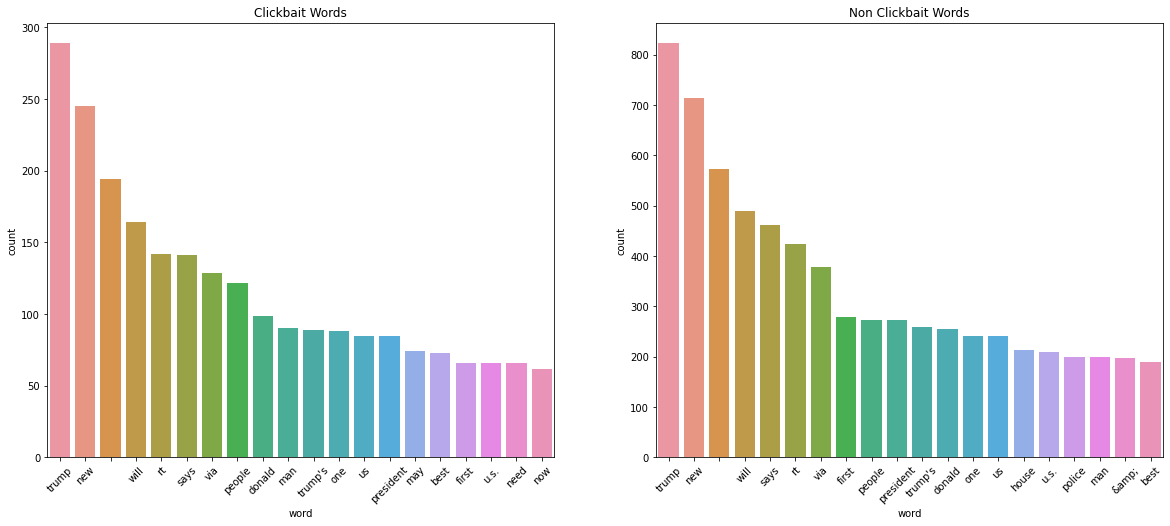

In [93]:
#Common Words
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

sns.barplot(data = clickbait_words_counter_df.sort_values('count',ascending=False).head(20),x='word',y='count',ax=ax1)#clickbait_words_counter.most_common(20))
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Clickbait Words")


#Common Words
sns.barplot(data = no_clickbait_words_counter_df.sort_values('count',ascending=False).head(20),x='word',y='count',ax=ax2)#clickbait_words_counter.most_common(20))
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title("Non Clickbait Words")
plt.show()

In [92]:
no_clickbait_words_counter_df.sort_values('count',ascending=False)

,word,count
7675,trump,823
659,new,714
7720,,574
6,will,490
178,says,462
...,...,...
15115,thicke:,1
15113,complaints:,1
15112,€16m,1
15110,mother',1


# Bigrams phrases and wordcloud

In [94]:
#Let's try bigrams and then wordcloud

from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import Text8Corpus

#Using gensim to detect common phrases from list of sentences


In [109]:
clickbait_sentences = []
for sent in X_train_df.loc[X_train_df['label']=='clickbait','postText']:
  clickbait_sentences.append(sent.split(" "))

no_clickbait_sentences = []
for sent in X_train_df.loc[X_train_df['label']=='no-clickbait','postText']:
  no_clickbait_sentences.append(sent.split(" "))

In [111]:
clickbait_sentences[0]

['U.S.',
 'Soccer',
 'should',
 'start',
 'answering',
 'tough',
 'questions',
 'about',
 'Hope',
 'Solo,',
 '@eric_adelson',
 'writes.']

In [113]:
common_terms=['of','with','without','and','or','the','a']

clickbait_phrases = Phrases(clickbait_sentences,min_count=1)# common_terms=common_terms)

no_clickbait_phrases = Phrases(no_clickbait_sentences,min_count=1)# common_terms=common_terms)


In [114]:
clickbait_Phraser = Phraser(clickbait_phrases)
no_clickbait_Phraser = Phraser(no_clickbait_phrases)


In [115]:
clickbait_bigrams=list(clickbait_Phraser[clickbait_postText])
no_clickbait_bigrams=list(no_clickbait_Phraser[no_clickbait_postText])

In [138]:
clickbait_words_bigrams = ''
for word in clickbait_bigrams:
  if word.lower() not in stopwords:
    clickbait_words_bigrams+=word.lower() +" "

no_clickbait_words_bigrams = ''
for word in no_clickbait_bigrams:
  if word.lower() not in stopwords:
    no_clickbait_words_bigrams+=word.lower()  + " "

In [139]:
clickbait_words_bigrams

'u.s. soccer start answering tough questions_about hope solo, @eric_adelson writes. light bulbs hurt your_health? one company is_now putting warning_labels bulbs: 13 classic ’00s songs_that actually meant artists tourists detained_in malaysia getting naked sacred mountain: the_brutal dictatorship_the world_keeps ignoring rt_@bbcwalesnews: caerphilly farmer may_get payout worth hundreds_of thousands 24 year wait man_dies car plunges parking garage 5 inconsistencies \'jurassic_world\' that_will drive scientists crazy @bi_video rt_@bbcos: the_secret history_of women\'s_football how_do dogs donate blood? global_warming skeptics their_own conference tell winning debate. nobel-winning sexism lab via @roomfordebate 5_incredible italian_dishes you_haven\'t tried_before rt @indyfootball: player ratings: jack wilshere comes age phil jones andros townsend endure shocker htt the_strongest female characters #jurassicworld humans map: islamic state neighborhood near you? academic group censures univ

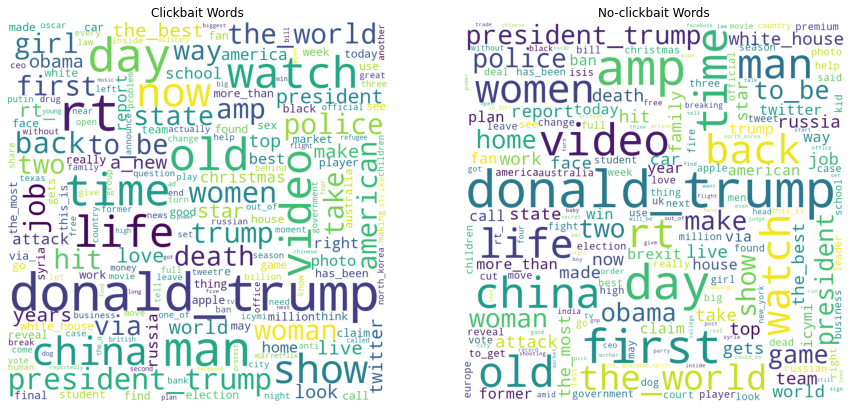

In [140]:
clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = custom_stopwords,min_font_size = 10).generate(clickbait_words_bigrams)
no_clickbait_wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      stopwords = custom_stopwords,min_font_size = 10).generate(no_clickbait_words_bigrams)

# plot the WordCloud image                        
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))

#plt.figure(figsize = (20, 20), facecolor = None) 
ax1.imshow(clickbait_wordcloud) 
ax1.axis("off") 
ax1.set_title("Clickbait Words")

ax2.imshow(no_clickbait_wordcloud) 
ax2.axis("off") 
ax2.set_title("No-clickbait Words")
  
plt.show()

In [141]:
clickbait_words_bigrams_counter = collections.Counter(clickbait_words_bigrams.split(' '))
no_clickbait_words_bigrams_counter = collections.Counter(no_clickbait_words_bigrams.split(' '))

clickbait_words_bigrams_counter_df = pd.DataFrame.from_dict(clickbait_words_bigrams_counter, orient='index').reset_index()
clickbait_words_bigrams_counter_df.columns=['word','count']

no_clickbait_words_bigrams_counter_df = pd.DataFrame.from_dict(no_clickbait_words_bigrams_counter, orient='index').reset_index()
no_clickbait_words_bigrams_counter_df.columns=['word','count']


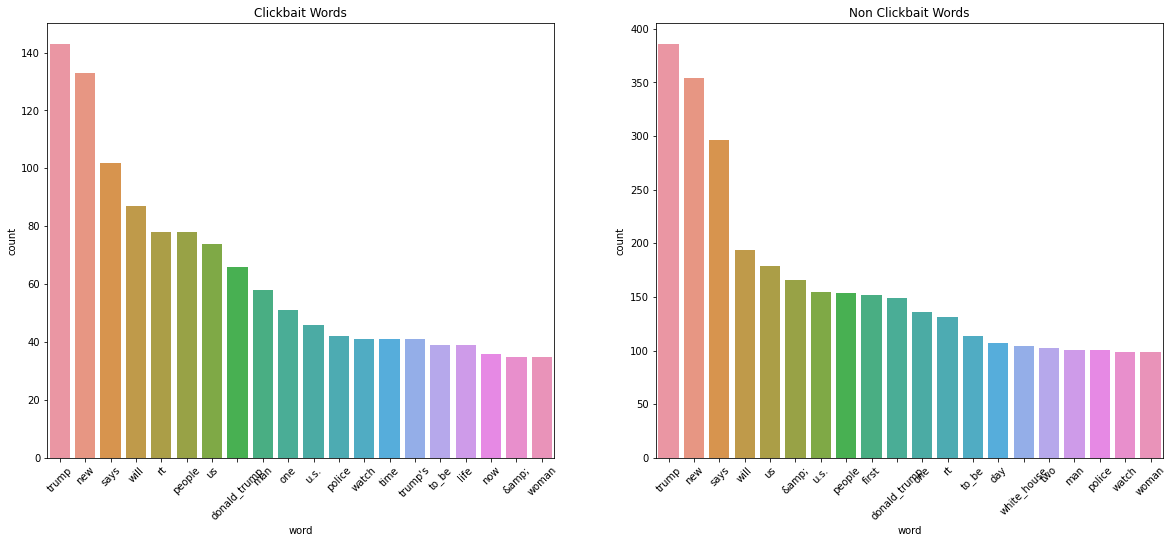

In [142]:
#Common Words
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

sns.barplot(data = clickbait_words_bigrams_counter_df.sort_values('count',ascending=False).head(20),x='word',y='count',ax=ax1)#clickbait_words_counter.most_common(20))
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Clickbait Words")


#Common Words
sns.barplot(data = no_clickbait_words_bigrams_counter_df.sort_values('count',ascending=False).head(20),x='word',y='count',ax=ax2)#clickbait_words_counter.most_common(20))
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title("Non Clickbait Words")
plt.show()

In [143]:
# We can see that many words are common in above two plots.

#EDA

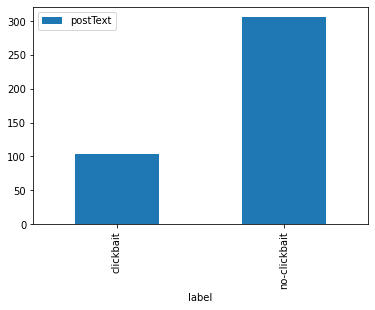

In [146]:
# postText contaning !
X_train_df[X_train_df['postText'].str.contains('!')][['postText','label']].groupby('label').count().plot(kind='bar')

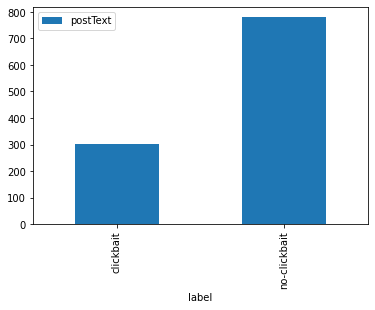

In [147]:
# postText contaning ?

X_train_df[X_train_df['postText'].str.contains('\?')][['postText','label']].groupby('label').count().plot(kind='bar')

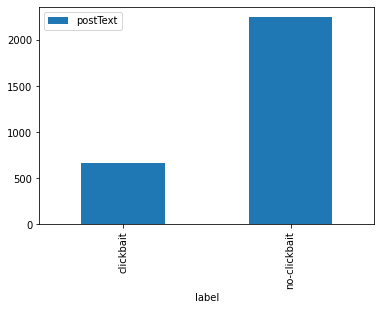

In [148]:
# postText contaning rt
X_train_df[X_train_df['postText'].str.contains('rt')][['postText','label']].groupby('label').count().plot(kind='bar')


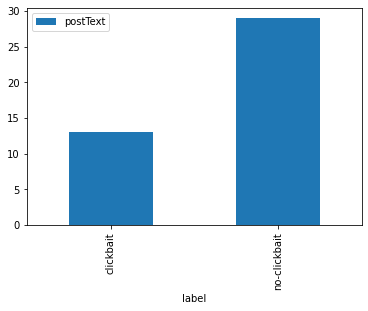

In [149]:
# postText contaning * (possible cuss words)
X_train_df[X_train_df['postText'].str.contains('\*')][['postText','label']].groupby('label').count().plot(kind='bar')


# Word2Vec

In [156]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [157]:
postTexts=list(X_train_df['postText'])


In [163]:
all_sentences=[]
for sent in postTexts:
  all_sentences.append(nltk.word_tokenize(sent.lower()))

In [164]:
all_sentences[30]

['rt',
 '@',
 'bbcos',
 ':',
 'the',
 'secret',
 'history',
 'of',
 'women',
 "'s",
 'football']

In [165]:
#Phrase detection

common_terms=['of','with','without','and','or','the','a']

phrases = Phrases(all_sentences,common_terms=common_terms)# common_terms=common_terms)

bigram = Phraser(phrases)

all_sentences=list(bigram[all_sentences])


In [166]:
all_sentences[30]

['rt_@',
 'bbcos',
 ':',
 'the',
 'secret',
 'history',
 'of',
 'women',
 "'s",
 'football']

In [170]:
## CHeck with google embeddings

#CBOW
word2vec_model_cbow = Word2Vec(all_sentences,size=200,min_count=1,window=5,sg=0)
#SG
word2vec_model_sg = Word2Vec(all_sentences,size=200,min_count=1,window=5,sg=1)

In [172]:
word2vec_dict_sg = dict(zip(word2vec_model_sg.wv.index2word, word2vec_model_sg.wv.syn0))
word2vec_dict_cbow = dict(zip(word2vec_model_cbow.wv.index2word, word2vec_model_cbow.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
word2vec_dict_sg['alas']


In [176]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [177]:
#need a better way to do this
def sentence_embedding(sentence,embedding_dict):
  words = str(sentence).lower()
  words = nltk.word_tokenize(words)

  embeddings=[]
  for word in words:
    if word in embedding_dict:
      embeddings.append(embedding_dict[word])

  embeddings = np.array(embeddings)
  v = embeddings.sum(axis=0)

  return (v/np.sqrt((v**2).sum())).tolist()



In [179]:
X_train_df['sentence_embeddings_cbow'] = X_train_df['postText'].apply(lambda x:sentence_embedding(x,word2vec_dict_cbow))

In [181]:
X_train_df['sentence_embeddings_sg'] = X_train_df['postText'].apply(lambda x:sentence_embedding(x,word2vec_dict_sg))

In [182]:
X_train_df.iloc[2720,:]

id                                                         850909692721332224
postTimestamp                                  Sun Apr 09 03:14:14 +0000 2017
postText                    Jeff Sessions Slams Deal to Monitor Baltimore ...
postMedia                                                                  []
targetTitle                 Jeff Sessions Slams Deal to Monitor Baltimore ...
targetDescription           Jeff Sessions Slams Deal to Monitor Baltimore ...
targetKeywords              Attorney General Jeff Session, Baltimore, Fred...
targetParagraphs            [Attorney General Jeff Sessions issued a state...
targetCaptions              [Sean Penn on His Former Producer Steve Bannon...
label                                                            no-clickbait
sentence_embeddings_cbow    [-0.08536096662282944, 0.1065143570303917, -0....
sentence_embeddings_sg      [-0.07943344861268997, 0.1145954504609108, -0....
Name: 2720, dtype: object

In [183]:
X_train_embeddings_sg_df=pd.DataFrame()
for i in range(len(X_train_df['sentence_embeddings_sg'])):
  X_train_embeddings_sg_df=X_train_embeddings_sg_df.append(pd.DataFrame(X_train_df['sentence_embeddings_sg'][i]).T,ignore_index=True)

In [184]:
X_tsne = TSNE(n_components=2).fit_transform(X_train_embeddings_sg_df)
X_tsne.shape

(17597, 2)

In [185]:
df_results=pd.DataFrame()

In [191]:
df_results['class']=y_train.label

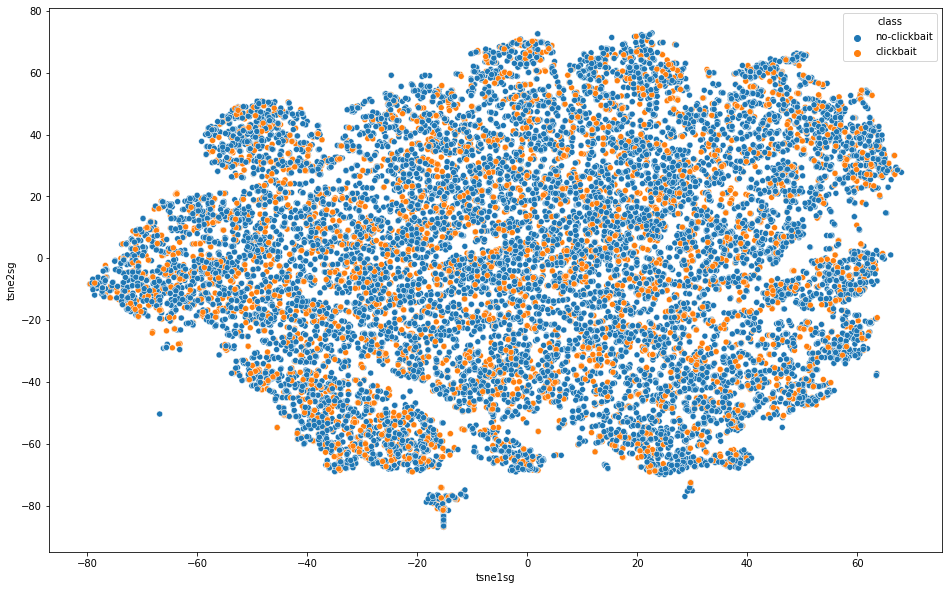

In [193]:
df_results['tsne1sg'] = X_tsne[:,0]
df_results['tsne2sg'] = X_tsne[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1sg", y="tsne2sg",
    hue="class",
    data=df_results,
    legend="full",
)

In [194]:
PCA_sg = PCA(n_components=2).fit_transform(X_train_embeddings_sg_df)
PCA_sg.shape

(17597, 2)

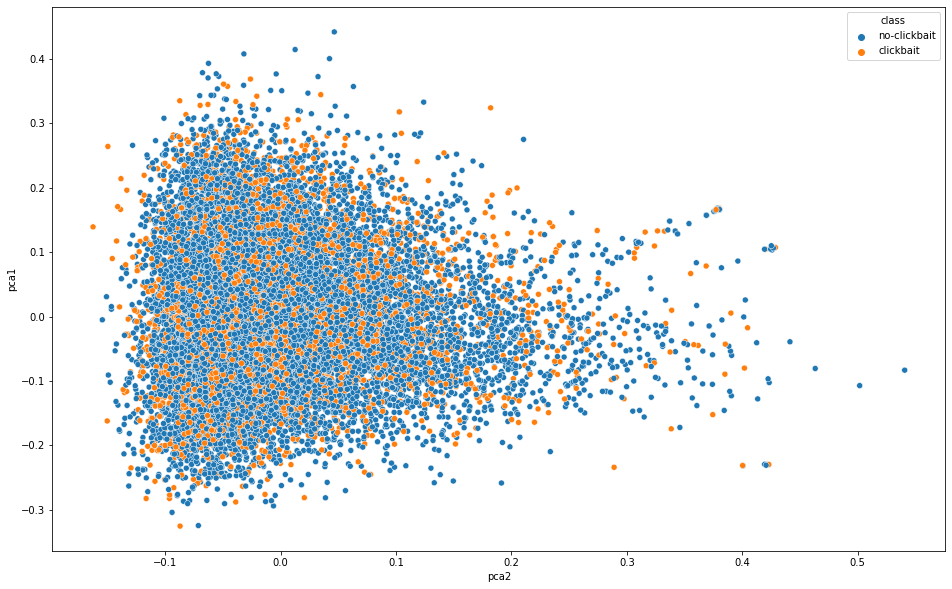

In [196]:
df_results['pca1'] = PCA_sg[:,0]
df_results['pca2'] = PCA_sg[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca2", y="pca1",
    hue="class",
    data=df_results,
    legend="full",
)

In [197]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [198]:
# Fisher Projection to discriminate labels
lda = LinearDiscriminantAnalysis(n_components=2)
lda_sg = lda.fit(X_train_embeddings_sg_df, y_train).transform(X_train_embeddings_sg_df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(200, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [199]:
df_results['ld1']=lda_sg

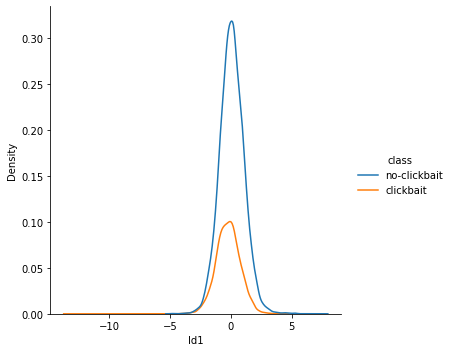

In [212]:
sns.displot(df_results, x="ld1", hue="class",kind="kde")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


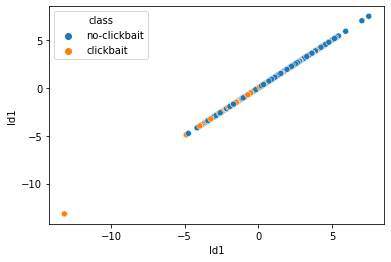

In [214]:
sns.scatterplot(df_results['ld1'],df_results['ld1'],hue=df_results['class'])

In [215]:
def parts_of_speech(text):
    words = text.split()
    nonstop = [word for word in words if word not in stopwords]
    pos = [part[1] for part in nltk.pos_tag(nonstop)]
    pos = ' '.join(pos)
    return pos

In [216]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [217]:
X_train_df['parts_of_speech'] = X_train_df['postText'].apply(parts_of_speech)

#not sure what to do with this